In [34]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [35]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [36]:
NUM_CLASSES = 26

# Dataset reading

In [37]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [38]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [41]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 26)                286       
                                                                 
Total params: 1356 (5.30 KB)
Trainable params: 1356 (5.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [43]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [44]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/5000
49/66 [=====================>........] - ETA: 0s - loss: 3.2578 - accuracy: 0.0555 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
66/66 [==============================] - 0s 3ms/step - loss: 3.2476 - accuracy: 0.0586 - val_loss: 3.1962 - val_accuracy: 0.0895
Epoch 2/5000
51/66 [======================>.......] - ETA: 0s - loss: 3.1779 - accuracy: 0.0873
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
66/66 [==============================] - 0s 2ms/step - loss: 3.1674 - accuracy: 0.0894 - val_loss: 3.0881 - val_accuracy: 0.1281
Epoch 3/5000
55/66 [========================>.....] - ETA: 0s - loss: 3.0739 - accuracy: 0.1111
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
66/66 [==============================] - 0s 2ms/step - loss: 3.0670 - accuracy: 0.1104 - val_loss: 2.9394 - val_accuracy: 0.1339
Epoch 4/5000
57/66 [========================>.....] - ETA: 0s - loss: 2.9435 - accuracy: 0.13

In [45]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

22/22 [==============================] - 0s 788us/step - loss: 1.1718 - accuracy: 0.6467


In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [47]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 29ms/step
[2.6775200e-05 9.1498010e-03 5.7026400e-04 3.7608219e-03 9.0575748e-04
 1.6546585e-03 3.8872051e-04 6.2150795e-02 7.6611298e-07 2.2983950e-06
 1.3340344e-01 5.8447615e-05 1.5194419e-04 2.0895537e-04 4.4025481e-04
 2.6512900e-05 8.6805818e-04 2.8307882e-01 5.4276125e-03 5.6312134e-04
 1.8691906e-01 2.7280211e-01 3.7351251e-02 1.5942951e-05 8.0092253e-09
 7.3784307e-05]
17


# Confusion matrix

88/88 [==============================] - 0s 644us/step


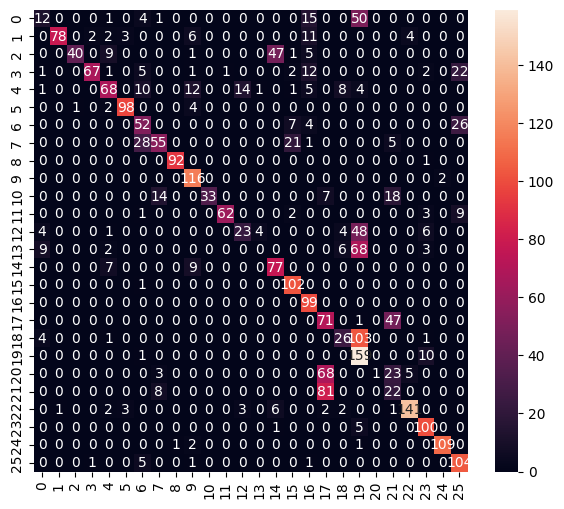

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.14      0.21        83
           1       0.99      0.74      0.84       106
           2       0.98      0.39      0.56       103
           3       0.96      0.59      0.73       114
           4       0.71      0.55      0.62       124
           5       0.94      0.93      0.94       105
           6       0.49      0.58      0.53        89
           7       0.68      0.50      0.58       110
           8       0.99      0.99      0.99        93
           9       0.76      0.98      0.86       118
          10       1.00      0.46      0.63        72
          11       0.98      0.81      0.89        77
          12       0.57      0.26      0.35        90
          13       0.00      0.00      0.00        88
          14       0.59      0.83      0.69        93
          15       0.75      0.99      0.85       103
          16       0.65      1.00      0.79        99
     

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [49]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [50]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpudjdx0ij\assets


INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpudjdx0ij\assets


7540

# Inference test

In [51]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [52]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [53]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [54]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.6775182e-05 9.1497963e-03 5.7026406e-04 3.7608205e-03 9.0575678e-04
 1.6546572e-03 3.8872022e-04 6.2150795e-02 7.6611167e-07 2.2983954e-06
 1.3340344e-01 5.8447680e-05 1.5194407e-04 2.0895523e-04 4.4025472e-04
 2.6512878e-05 8.6805754e-04 2.8307888e-01 5.4276083e-03 5.6312123e-04
 1.8691905e-01 2.7280217e-01 3.7351251e-02 1.5942953e-05 8.0092111e-09
 7.3784387e-05]
17
